<a href="https://colab.research.google.com/github/fauzinurfalah/SentimentIMDB/blob/main/KEL3_DATA_MINING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kelompok 3 Data Mining
1. Ahda Faizalziddi Al Aziz     (STI202303600)
2. Ilham Aufa Nugroho           (STI202303346)
3. Fauzi Nur Falah              (STI202303409)
4. Muhammad Syarif Hidayatullah (STI202303527)
5. Tri Wahyu Hidayat            (STI202303353)
6. Muhammad Roy Setiawan        (STI202303331)
7. Sahrur Anam                  (STI202303552)
8. Muh Januar Imam Saputra      (STI202202623)

In [ ]:
# Instal library
!pip install pandas numpy scikit-learn seaborn matplotlib nltk wordcloud imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

# ML & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# NLTK stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/IMDB_Dataset.csv'
df = pd.read_csv('IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Hapus nilai kosong
df.dropna(inplace=True)

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)          # hapus HTML tag
    text = re.sub(r'[^a-zA-Z]', ' ', text)     # hapus angka & simbol
    text = text.lower()                        # ubah ke huruf kecil
    text = text.split()                        # tokenisasi sederhana
    text = [word for word in text if word not in stop_words]  # hapus stopwords
    return ' '.join(text)

df.dropna(inplace=True)
df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'negative':0, 'positive':1})
df = df[['clean_review', 'label']].dropna()
df.head()


,clean_review,label
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

# Vectorizer & to_dense untuk SMOTE
tfidf = TfidfVectorizer(max_features=5000, min_df=2)
to_array = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)



In [ ]:
# Pipeline SMOTE untuk 2 model
pipelines = {
    "NaiveBayes_SMOTE": ImbPipeline(steps=[
        ("tfidf", tfidf),
        ("to_array", to_array),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("clf", MultinomialNB())
    ]),
    "LogReg_SMOTE": ImbPipeline(steps=[
        ("tfidf", tfidf),
        ("to_array", to_array),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("clf", LogisticRegression(max_iter=400))
    ])
}

In [ ]:
# Training, Prediksi, Evaluasi
rows = []
cms = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, pred, average='binary', pos_label=1, zero_division=0
    )
    cm = confusion_matrix(y_test, pred)

    rows.append([name, acc, prec, rec, f1])
    cms[name] = cm

results = pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1"]).sort_values("F1", ascending=False)
print(results.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

           Model  Accuracy  Precision  Recall     F1
    LogReg_SMOTE    0.8929     0.8869  0.9006 0.8937
NaiveBayes_SMOTE    0.8568     0.8506  0.8656 0.8580


In [ ]:
# Classification Report detail
for name, pipe in pipelines.items():
    pred = pipe.predict(X_test)
    print(f"\n=== Classification Report: {name} ===")
    print(classification_report(y_test, pred, digits=4))


=== Classification Report: NaiveBayes_SMOTE ===
              precision    recall  f1-score   support

           0     0.8632    0.8480    0.8555      5000
           1     0.8506    0.8656    0.8580      5000

    accuracy                         0.8568     10000
   macro avg     0.8569    0.8568    0.8568     10000
weighted avg     0.8569    0.8568    0.8568     10000


=== Classification Report: LogReg_SMOTE ===
              precision    recall  f1-score   support

           0     0.8990    0.8852    0.8921      5000
           1     0.8869    0.9006    0.8937      5000

    accuracy                         0.8929     10000
   macro avg     0.8930    0.8929    0.8929     10000
weighted avg     0.8930    0.8929    0.8929     10000



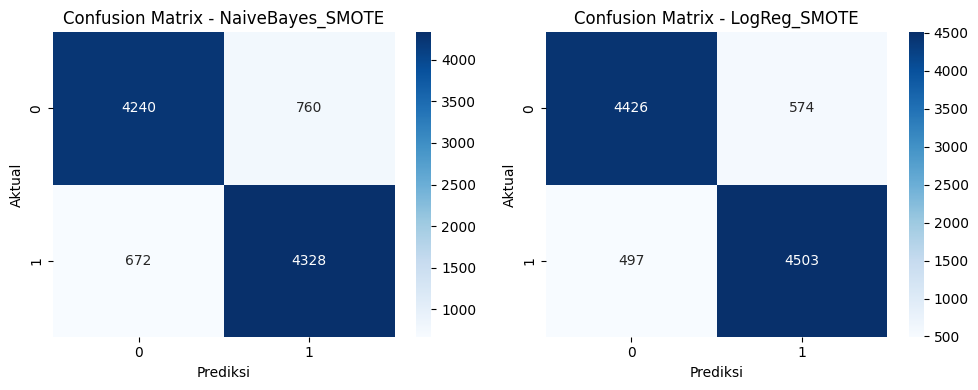

In [ ]:
# Plot Confusion Matrix untuk Kedua Model
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, (name, cm) in zip(axes, cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Prediksi")
    ax.set_ylabel("Aktual")
plt.tight_layout()
plt.show()


In [ ]:
best = results.iloc[0]
print(f"Model terbaik (berdasarkan F1): {best['Model']} | Acc={best['Accuracy']:.4f}, Prec={best['Precision']:.4f}, Rec={best['Recall']:.4f}, F1={best['F1']:.4f}")

Model terbaik (berdasarkan F1): LogReg_SMOTE | Acc=0.8929, Prec=0.8869, Rec=0.9006, F1=0.8937


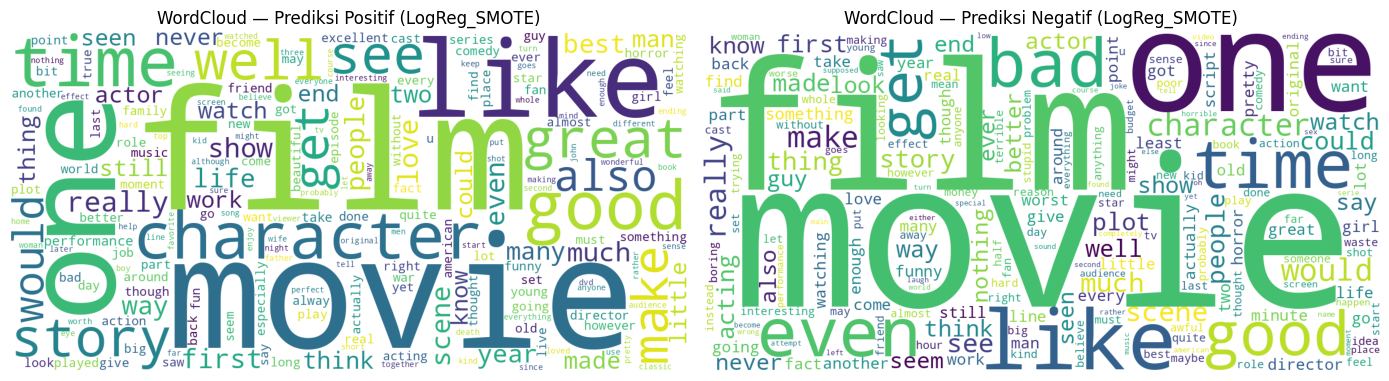

In [ ]:
wc_kwargs = dict(
    width=1200,
    height=600,
    background_color="white",
    stopwords=stop_words,
    collocations=False
)

# Ambil model terbaik dan prediksi
best_name = results.sort_values("F1", ascending=False).iloc[0]["Model"]
best_pipe = pipelines[best_name]
y_pred = best_pipe.predict(X_test)

# Buat DataFrame untuk analisis prediksi
test_df = pd.DataFrame({
    "text": X_test.values,
    "y_true": y_test.values,
    "y_pred": y_pred
})

# Gabungkan teks berdasarkan hasil prediksi
pos_pred_text = " ".join(test_df.loc[test_df["y_pred"] == 1, "text"].astype(str).values)
neg_pred_text = " ".join(test_df.loc[test_df["y_pred"] == 0, "text"].astype(str).values)

# Tampilkan WordCloud
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(**wc_kwargs).generate(pos_pred_text))
plt.title(f"WordCloud — Prediksi Positif ({best_name})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(**wc_kwargs).generate(neg_pred_text))
plt.title(f"WordCloud — Prediksi Negatif ({best_name})")
plt.axis("off")

plt.tight_layout()
plt.show()
